In [1]:
%reset -f 
# Limpiamos todas las variables

# TP Análisis de Datos   

Integrantes: 

| Code  | Nombre       | Apellido           | Correo                     |
| ----- | ------------ | ------------------ | -------------------------- |
| a1906 | Yandri Jair  | Uchuari Gallardo   | yandriuchuari@gmail.com    |
| a1823 | Luis Alberto | Santamaria Jimenez | santamaria.luigi@gmail.com |


Para la realizó de este TP se utilizó el Dataset de [**Recorridos en Ecobicis Realizados 2024**](https://data.buenosaires.gob.ar/dataset/bicicletas-publicas) 


Antes de responder las siguientes interrogantes realizar un análisis y comprensión del DataSet 

- ¿Hay diferencias en la duración de los viajes entre hombres y mujeres? 
- ¿Existen patrones temporales en la cantidad de viajes (horas pico, días de la semana, meses)? 


In [ ]:
# data analysis
import pandas as pd # pip install pandas
import numpy as np
from scipy.stats import mode # pip install scipy

### presentación de tablas & Gráficas 
import matplotlib.pyplot as plt # pip install matplotlib
import seaborn as sns # pip install seaborn
from IPython.display import display # Para mostrar el Styler en Jupyter/IPython
import missingno as msno 
from statistics import mode, StatisticsError


# Manejo de datos / ML
from sklearn.impute import KNNImputer # par aKNN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:
# código para cargar dataset .csv Utilizamos las librerías de panda
df_ecobici = pd.read_csv('./DataSet_TP_AD/badata_ecobici_recorridos_realizados_2024.csv')

# Comprensión de los datos 

Iniciamos viendo de manera vertical 5 datos al azar, el objetivo es tener una visión rápida del contenido de los datos.

In [65]:
# Listamos 5 registros de manera aleatoria para conocer su contenido 
df_ecobici.sample(5).T # vemos simepre 5 filas aleatorias y todas las columnas


,114201,1025481,2164980,3242600,2680109
id_recorrido,20376144,23358481,20780599,20608192,20495160
duracion_recorrido,1679,22,1408,911,943
fecha_origen_recorrido,2024-01-18 22:59:02,2024-10-08 20:07:52,2024-02-23 21:16:37,2024-02-08 18:37:54,2024-01-29 12:40:46
id_estacion_origen,150,458,13,215,302
nombre_estacion_origen,150 - RODRIGO BUENO,219 - Parque Chacabuco II,013 - ONCE,113 - Guatemala,340 - PLAZA NUEVA POMPEYA
direccion_estacion_origen,Av. España 2200,AV. ASAMBLEA 1400,Av. Pueyrredon & Av. Rivadavia,Guatemala 4773,3817 Traful
long_estacion_origen,-58.355465,-58.444007,-58.406,-58.424996,-58.415771
lat_estacion_origen,-34.618755,-34.636426,-34.61009,-34.585878,-34.651846
fecha_destino_recorrido,2024-01-18 23:27:01,2024-10-08 20:08:14,2024-02-23 21:40:05,2024-02-08 18:53:05,2024-01-29 12:56:29
id_estacion_destino,152,458,38,418,21


In [5]:
# TABLA RESUMEN DE CONTENIDO DEL DATASET 
# V3 corrige el exponencial, optimiza el calculo, quita redundancia del código, mejorar detección de decimales para los campos porcentajes hacer una estructura de if y testing con .parquet

def calcular_estadisticas_numericas(df):
    # +++++++++++ Calculo para columnas numéricas 
    #df_numeros = df.select_dtypes(exclude=['object'])
    df_numeros = df.select_dtypes(include=['number'])
    stats_numericas = {
        'Valor_min': df_numeros.min(),
        'Valor_max': df_numeros.max(),
        'Valor_mean': df_numeros.mean(),
        'std': df_numeros.std(),
        'var=0': (df_numeros == 0).sum(),
        #'%var=0': ((df_numeros == 0).sum() / len(df) * 100).round(2),
        # mejorar # '%var=0': (df.apply(lambda x: (x == 0).sum() if pd.api.types.is_numeric_dtype(x) else 0) / len(df) * 100).round(2),
        'var<0': (df_numeros < 0).sum(),
        #'var<1': (df_numeros < 1).sum(),
        #'%var<1': ((df_numeros < 1).sum() / len(df) * 100).round(2)
        
    }
    return pd.DataFrame(stats_numericas)

def calcular_estadisticas_generales(df):
    # +++++++++++++++ Calcula estadísticas generales para todas las columnas 
    total_registros = len(df)
    nulos = df.isnull().sum()
    stats_generales = {
        'Tipo_Dato': df.dtypes,
        'Valor_Unico': df.nunique(),
        'Null': nulos,
        'Null%': (nulos / total_registros * 100).round(2),
        'NotNull': df.count(),
        'NotNull%': (df.count() / total_registros * 100).round(2)
    }
    return pd.DataFrame(stats_generales)

def analisis_detallado(df):
    # ++++++++++++++ Realiza un análisis detallado del DataFrame 
    # Estadísticas generales
    resumen_general = calcular_estadisticas_generales(df)
    
    # Estadísticas numéricas
    resumen_numericas = calcular_estadisticas_numericas(df)
    
    # Combinar ambos resúmenes
    resumen = resumen_general.join(resumen_numericas, how='outer')
    return resumen

# Ejecución del análisis
tabla_resumen_df = analisis_detallado(df_ecobici)

# Salida en pantalla
print(f"Matriz del DataSet: {df_ecobici.shape}")
print(f"Cantidad total de registros: {len(df_ecobici)} \n")
print("----- TABLA RESUMEN DE CONTENIDO DEL DATASET  -----")

# Mostrar la tabla con formato
tabla_resumen_df.style.set_properties(**{'text-align': 'right'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)


# Limpiar variables mejorar =( Colocar en Otro Campo)
#del tabla_resumen_df

Matriz del DataSet: (3559284, 17)
Cantidad total de registros: 3559284 

----- TABLA RESUMEN DE CONTENIDO DEL DATASET  -----


,Tipo_Dato,Valor_Unico,Null,Null%,NotNull,NotNull%,Valor_min,Valor_max,Valor_mean,std,var=0,var<0
direccion_estacion_destino,object,395,0,0.000000,3559284,100.000000,nan,nan,nan,nan,nan,nan
direccion_estacion_origen,object,393,0,0.000000,3559284,100.000000,nan,nan,nan,nan,nan,nan
duracion_recorrido,int64,19543,0,0.000000,3559284,100.000000,0.000000,2571165.000000,1274.826768,9584.216120,37618.000000,0.000000
fecha_destino_recorrido,object,3220154,3379,0.090000,3555905,99.910000,nan,nan,nan,nan,nan,nan
fecha_origen_recorrido,object,3227772,0,0.000000,3559284,100.000000,nan,nan,nan,nan,nan,nan
genero,object,3,11946,0.340000,3547338,99.660000,nan,nan,nan,nan,nan,nan
id_estacion_destino,int64,398,0,0.000000,3559284,100.000000,2.000000,577.000000,237.149746,165.710164,0.000000,0.000000
id_estacion_origen,int64,395,0,0.000000,3559284,100.000000,2.000000,577.000000,235.606380,165.799385,0.000000,0.000000
id_recorrido,int64,3559283,0,0.000000,3559284,100.000000,20180969.000000,24503283.000000,22341233.896882,1257090.334643,0.000000,0.000000
id_usuario,float64,262673,0,0.000000,3559284,100.000000,24.000000,1280599.000000,790885.096433,388216.940843,0.000000,0.000000


In [6]:
 # Limpiar variables por tabla 
del tabla_resumen_df

Entre los datos mas relevantes podemos observar en la <u>TABLA RESUMEN DE CONTENIDO DEL DATASET</u> 
- Tipos de datos interpretados por **pandas** en cada uno de los campos del dataframe 
- Cantidad de datos NULL que presentamos en los campos **genero** que representan el 0.34% y **fecha_destino_recorrido** que representan el 0.09% 
- El campo **duracion_recorrido** posee 37.618 registros  con valor **0** Correspondiente al 1.06% de 3.559.284 registros, este campo se almacena el tiempo del viaje. desconocemos si esta expresado en minutos o segundos  

In [7]:
# Consulta de registros donde duracion_recorrido = 0 
registros = df_ecobici[df_ecobici['duracion_recorrido'] == 0]
registros.sample(5)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
1834709,21017076,0,2024-03-13 20:20:56,467,328 - SARMIENTO II,Sarmiento 2037,-58.395893,-34.605514,2024-03-13 20:20:56,149,149 - LIMA,México & Lima,-58.381364,-34.615327,38613.0,FIT,MALE
437826,23406101,0,2024-10-12 11:22:20,284,229 - RIGLOS,1019 Riglos,-58.435056,-34.631018,2024-10-12 11:22:20,381,274 - Gavilán,Gavilán 1200,-58.465884,-34.616247,274.0,FIT,MALE
2305913,21995475,0,2024-06-09 17:01:44,234,344 - UNIVERSIDAD DI TELLA,Figueroa Alcorta 7285,-58.446802,-34.547232,2024-06-09 17:01:44,14,014 - Pacifico,"Santa Fe Av. & Bullrich, Int. Av.",-58.426387,-34.577424,994462.0,FIT,FEMALE
1090101,24167425,0,2024-12-04 21:30:37,6,006 - Parque Lezama,"Avenida Martin Garcia, 295",-58.369758,-34.628526,NaN,59,018 - Independencia,Idependencia y Bernardo de Irigoyen,-58.380565,-34.617654,671116.0,FIT,FEMALE
2205794,20771590,0,2024-02-23 11:53:13,60,060 - 25 De Mayo,527 25 De Mayo,-58.371079,-34.601651,2024-02-23 11:53:13,114,114 - TORRE MACRO,Av. Eduardo Madero 1180,-58.371424,-34.593989,1115518.0,FIT,MALE


In [8]:
# Consulta registros id_estacion_origen'] == 213 y id_estacion_destino'] == 316) para ver patron con duración de recorrido 
registros = df_ecobici[(df_ecobici['id_estacion_origen'] == 213) & (df_ecobici['id_estacion_destino'] == 316)]
registros.sample(6)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
2019034,23071681,346,2024-09-19 09:53:55,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-09-19 09:59:41,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,43637.0,FIT,MALE
1742775,23179085,384,2024-09-26 17:11:36,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-09-26 17:18:00,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,716755.0,ICONIC,MALE
2381952,23847313,371,2024-11-12 19:20:18,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-11-12 19:26:29,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,603061.0,FIT,MALE
1527530,22227291,2,2024-07-02 10:57:23,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-07-02 10:57:25,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,43637.0,ICONIC,MALE
1006726,23370081,424,2024-10-09 15:18:57,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-10-09 15:26:01,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,1150412.0,FIT,FEMALE
2327852,20898410,488,2024-03-04 17:00:02,213,136 - Acevedo,Acevedo y Padilla,-58.442685,-34.599659,2024-03-04 17:08:10,316,205 - SAN MARTIN,1471 Cucha Cucha,-58.453475,-34.605567,1115467.0,FIT,MALE


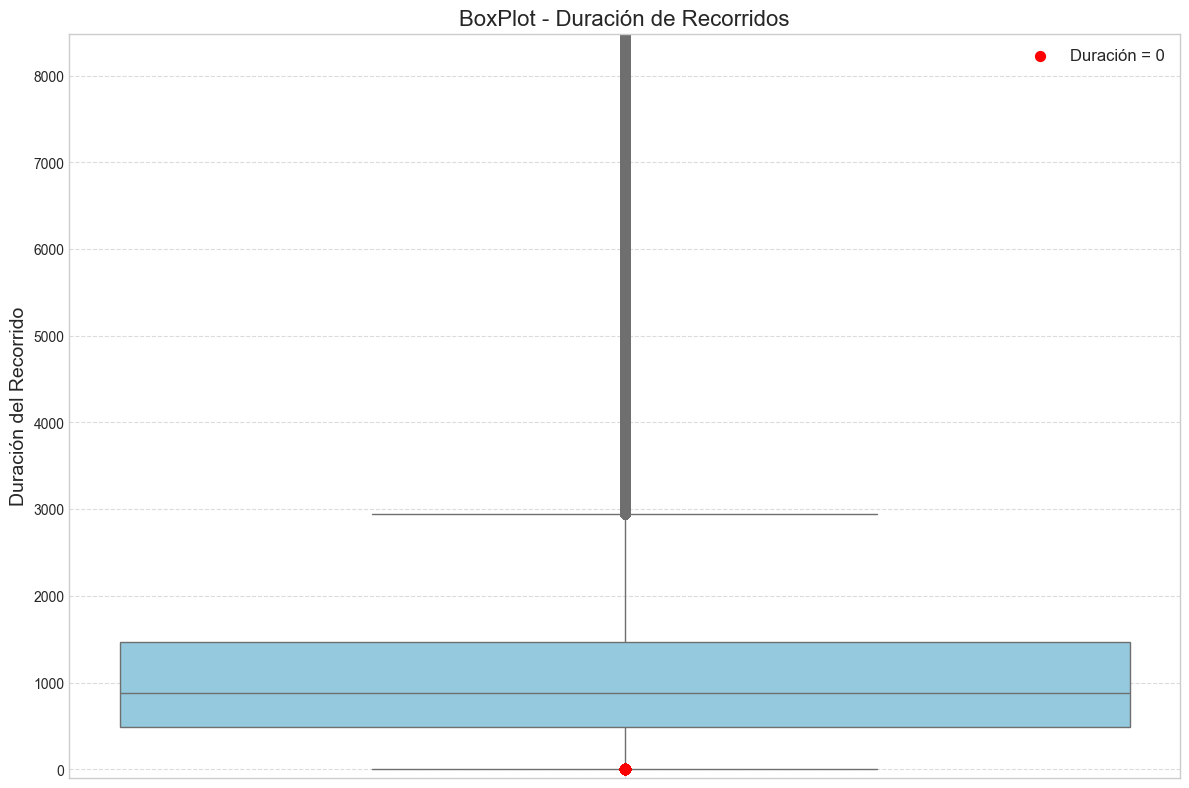

In [9]:
# gráfica de boxplot para duracion_recorrido

# Configurar el estilo y tamaño de la figura
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# Crear el box plot con todos los registros
ax = sns.boxplot(y=df_ecobici['duracion_recorrido'], color='skyblue')

# Destacar los valores con duración 0
ceros = df_ecobici[df_ecobici['duracion_recorrido'] == 0]
if not ceros.empty:
    plt.scatter(x=np.zeros(len(ceros)), y=ceros['duracion_recorrido'],
                color='red', label='Duración = 0', s=50, zorder=3)

# Añadir título y etiquetas
plt.title('BoxPlot - Duración de Recorridos', fontsize=16)
plt.ylabel('Duración del Recorrido', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Ajustar los límites del eje y para mejorar la visualización si es necesario
y_max = np.percentile(df_ecobici['duracion_recorrido'], 99.5)    # pruebas ok 
plt.ylim(-100, y_max)  # Inicio negativo para dar espacio a los valores 0

plt.tight_layout()
plt.show()

In [10]:
# Tabla describe de los valores numéricos 
print(f'Valor del cuartil Q1 - Box Plot duracion_recorrido {4.930000e+02:.2f}')
print(f'Valor media, cuartil Q2 - Box Plot duracion_recorrido {8.810000e+02:.2f}')
print(f'Valor del cuartil Q3 - Box Plot duracion_recorrido {1.474000e+03:.2f}')
#print(f'{2.571165e+06:.2f}') # valor max 

df_ecobici.describe().T

Valor del cuartil Q1 - Box Plot duracion_recorrido 493.00
Valor media, cuartil Q2 - Box Plot duracion_recorrido 881.00
Valor del cuartil Q3 - Box Plot duracion_recorrido 1474.00


,count,mean,std,min,25%,50%,75%,max
id_recorrido,3559284.0,2.234123e+07,1.257090e+06,2.018097e+07,2.123850e+07,2.235117e+07,2.343694e+07,2.450328e+07
duracion_recorrido,3559284.0,1.274827e+03,9.584216e+03,0.000000e+00,4.930000e+02,8.810000e+02,1.474000e+03,2.571165e+06
id_estacion_origen,3559284.0,2.356064e+02,1.657994e+02,2.000000e+00,9.300000e+01,1.990000e+02,3.780000e+02,5.770000e+02
long_estacion_origen,3559284.0,-5.842301e+01,3.828674e-02,-5.852710e+01,-5.844965e+01,-5.842095e+01,-5.839374e+01,-5.835547e+01
lat_estacion_origen,3559284.0,-3.459876e+01,2.440911e-02,-3.468777e+01,-3.461635e+01,-3.460075e+01,-3.458255e+01,-3.453669e+01
id_estacion_destino,3559284.0,2.371497e+02,1.657102e+02,2.000000e+00,9.600000e+01,2.000000e+02,3.790000e+02,5.770000e+02
long_estacion_destino,3559284.0,-5.842318e+01,3.846726e-02,-5.852710e+01,-5.844966e+01,-5.842095e+01,-5.839374e+01,-5.835547e+01
lat_estacion_destino,3559284.0,-3.459895e+01,2.476879e-02,-3.468777e+01,-3.461649e+01,-3.460075e+01,-3.458234e+01,-3.453669e+01
id_usuario,3559284.0,7.908851e+05,3.882169e+05,2.400000e+01,5.118240e+05,9.133600e+05,1.113537e+06,1.280599e+06


In [11]:
# outliers --- Box Plot superiores - método IQR Q3
Q1 = df_ecobici['duracion_recorrido'].quantile(0.25)
Q3 = df_ecobici['duracion_recorrido'].quantile(0.75)
# Rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir límite superior para outliers
upper_bound = Q3 + 1.5 * IQR

# buscar solo los outliers superiores
upper_outliers = df_ecobici[df_ecobici['duracion_recorrido'] > upper_bound]

#registros = df_ecobici[(df_ecobici['duracion_recorrido'] == 0) & 
#                       (df_ecobici['id_estacion_origen'] == 517) & 
#                       (df_ecobici['id_estacion_destino'] == 14)]


print(f"Tercer cuartil (Q3): {Q3:.2f}")
print(f"Total de outliers superiores detectados: {len(upper_outliers)}") #`len` retorna número de elementos de un objeto iterable
print(f"Límite superior máximo  Box Plot  {upper_bound:.2f} > considerado atípico/outliers, listamos 6 registros para ver su contenido \n")
upper_outliers.sample(6)



Tercer cuartil (Q3): 1474.00
Total de outliers superiores detectados: 197787
Límite superior máximo  Box Plot  2945.50 > considerado atípico/outliers, listamos 6 registros para ver su contenido 



,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
599910,23357318,4089,2024-10-08 18:53:10,281,350 - Plaza Irlanda,Av. Gaona 2200,-58.458315,-34.613778,2024-10-08 20:01:19,262,349 - Plaza Saenz Peña,Andrés Lamas 1699,-58.467297,-34.609709,1222213.0,FIT,MALE
712918,23429001,8946,2024-10-14 18:37:51,372,322 - MARTÍ Y DIRECTORIO,"404 Marti, Jose",-58.470136,-34.636406,2024-10-14 21:06:57,148,323 - Parque Avellaneda II,Av. Directorio 4295,-58.484555,-34.645177,1229151.0,FIT,MALE
3097190,23735380,4582,2024-11-05 15:26:34,190,190 - JUNCAL,"Juncal & Salguero, Jeronimo",-58.411114,-34.585076,2024-11-05 16:42:56,166,166 - Cementerio de Recoleta,Vicente López 2100,-58.394148,-34.588347,1187040.0,FIT,FEMALE
1499730,22296849,3363,2024-07-09 16:13:56,490,245 - COSTANERA NORTE,AV. Costanera Rafael del Obligado 1700,-58.402021,-34.564771,2024-07-09 17:09:59,60,060 - 25 De Mayo,527 25 De Mayo,-58.371079,-34.601651,953254.0,ICONIC,MALE
973990,21305324,14738,2024-04-08 00:31:10,17,017 - Plaza Almagro,"441 Bulnes & Peron, Juan Domingo, Tte. General",-58.418731,-34.606410,2024-04-08 04:36:48,35,035 - INGENIERO BUTTY,Ing. E. Butty 291,-58.371847,-34.596425,1139699.0,FIT,MALE
2329897,20898660,7769,2024-03-04 17:09:26,457,110 - PLAZA CD DE BANFF,ROMA 786,-58.521740,-34.628050,2024-03-04 19:18:55,457,110 - PLAZA CD DE BANFF,ROMA 786,-58.521740,-34.628050,1122398.0,FIT,MALE


En la lista anterior se mostró una lista de registros outliers  de manera aleatoria, a continuación listamos   id_estacion_origen = 194 y id_estacion_destino= 63 y vemos que tienen tiempos de duración distintas sin patron, podríamos asumir que los datos son legítimos y no forman parte de outliers

In [ ]:
# Consulta registros id_estacion_origen'] == 194 y id_estacion_destino'] == 63) para ver patron con duración de recorrido194 duracion_recorrido'] < 2945) ]
registros = df_ecobici[(df_ecobici['id_estacion_origen'] == 194) & (df_ecobici['id_estacion_destino'] == 63)
                       & (df_ecobici['duracion_recorrido'] < 2945) ]


registros.sample(5)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
1551567,20950631,2368,2024-03-07 11:38:53,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-03-07 12:18:21,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1115627.0,FIT,FEMALE
1219281,21029118,1747,2024-03-15 03:05:13,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-03-15 03:34:20,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1036173.0,ICONIC,MALE
2280436,23979512,1631,2024-11-21 18:24:44,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-11-21 18:51:55,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1160704.0,ICONIC,MALE
3480697,21647705,1475,2024-05-08 18:30:10,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-05-08 18:54:45,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1148106.0,ICONIC,MALE
1413416,21029119,1732,2024-03-15 03:05:21,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-03-15 03:34:13,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1011295.0,FIT,OTHER


In [66]:
# Consulta registros id_estacion_origen'] == 213 y id_estacion_destino'] == 316) para ver patron con duración de recorrido 
registros = df_ecobici[(df_ecobici['id_estacion_origen'] == 194) & (df_ecobici['id_estacion_destino'] == 63)
                       & (df_ecobici['duracion_recorrido'] > 2945) ]


registros.sample(1)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
1029334,22410869,2998,2024-07-21 17:34:52,194,194 - PERÓN Y ACUÑA DE FIGUEROA,3997 TTE. GENERAL JUAN DOMINGO PERON,-58.422463,-34.606076,2024-07-21 18:24:50,63,063 - Reconquista,Viamonte 555,-58.374687,-34.599778,1025441.0,ICONIC,MALE


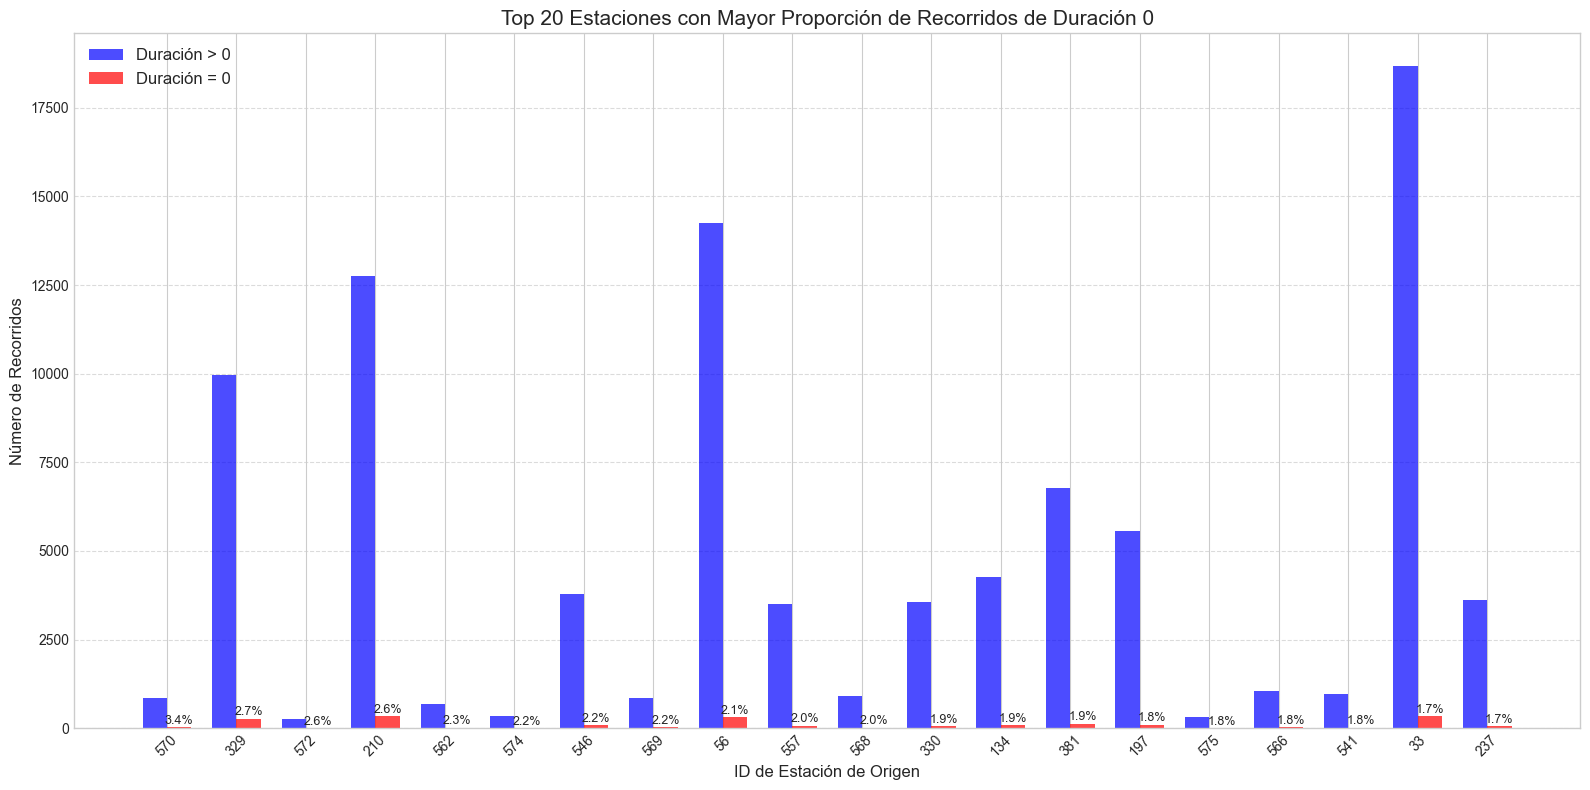

In [14]:
# Gráfico de barras por estación

# Configurar el estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

# Contar ocurrencias de duración 0 por estación de origen
zero_by_origin = df_ecobici[df_ecobici['duracion_recorrido'] == 0].groupby('id_estacion_origen').size()
normal_by_origin = df_ecobici[df_ecobici['duracion_recorrido'] > 0].groupby('id_estacion_origen').size()

# Combinar los datos y ordenar por el porcentaje de valores 0
combined = pd.DataFrame({
    'zero': zero_by_origin,
    'normal': normal_by_origin
}).fillna(0)

combined['total'] = combined['zero'] + combined['normal']
combined['percent_zero'] = (combined['zero'] / combined['total']) * 100
combined = combined.sort_values('percent_zero', ascending=False).head(20)  # Top 20 estaciones

# Preparar datos para la gráfica
labels = combined.index.astype(int)
zero_counts = combined['zero']
normal_counts = combined['normal']

# Configurar las barras
bar_width = 0.35
x = np.arange(len(labels))

# Crear las barras
plt.bar(x - bar_width/2, normal_counts, bar_width, label='Duración > 0', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, zero_counts, bar_width, label='Duración = 0', color='red', alpha=0.7)

# Añadir porcentajes sobre las barras de duración 0
for i, (_, row) in enumerate(combined.iterrows()):
    if row['zero'] > 0:
        plt.text(i + bar_width/2, row['zero'] + 5, f"{row['percent_zero']:.1f}%", 
                 ha='center', va='bottom', fontsize=9, rotation=0)

# Configuración del gráfico
plt.title('Top 20 Estaciones con Mayor Proporción de Recorridos de Duración 0', fontsize=15)
plt.xlabel('ID de Estación de Origen', fontsize=12)
plt.ylabel('Número de Recorridos', fontsize=12)
plt.xticks(x, labels, rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', axis='y', alpha=0.7)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [15]:
# Consulta de registros id_estacion_origen = 213 y  id_estacion_destin = 534  y 'duracion_recorrido'] == 0)
registros = df_ecobici[(df_ecobici['duracion_recorrido'] == 0) & 
                       (df_ecobici['id_estacion_origen'] == 210) & 
                       (df_ecobici['id_estacion_destino'] == 210)]

registros.sample(7)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
365246,22471004,0,2024-07-27 21:30:41,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-07-27 21:30:41,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1184236.0,FIT,MALE
61615,21460295,0,2024-04-19 17:24:56,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-04-19 17:24:56,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1146247.0,FIT,MALE
2231702,22830520,0,2024-09-02 11:26:25,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-09-02 11:26:25,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1199180.0,FIT,MALE
2078566,24048203,0,2024-11-26 19:28:10,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-11-26 19:28:10,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1229199.0,FIT,FEMALE
626344,21291629,0,2024-04-06 12:53:38,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-04-06 12:53:38,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1140743.0,FIT,MALE
2325400,23014228,0,2024-09-15 19:39:40,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-09-15 19:39:40,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1207928.0,ICONIC,MALE
1896299,22911508,0,2024-09-07 17:10:59,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2024-09-07 17:10:59,210,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,1034319.0,FIT,FEMALE


In [16]:
# Lista de registros filtrando duracion_recorrido'] == 0) & 'id_estacion_origen y id_estacion_destino'] == 239) & 
registros = df_ecobici[(df_ecobici['duracion_recorrido'] == 0) & 
                       (df_ecobici['id_estacion_origen'] == 239) & 
                       (df_ecobici['id_estacion_destino'] == 239)]

registros.sample(7)



,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
308652,24413981,0,2024-12-23 12:33:03,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-12-23 12:33:03,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,219275.0,ICONIC,OTHER
283486,24410303,0,2024-12-23 07:54:45,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-12-23 07:54:45,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,1264495.0,FIT,MALE
308721,24411325,0,2024-12-23 09:07:00,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-12-23 09:07:00,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,574047.0,FIT,FEMALE
2360380,23795577,0,2024-11-08 18:17:56,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-11-08 18:17:56,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,1246153.0,ICONIC,FEMALE
486819,24411257,0,2024-12-23 09:02:38,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-12-23 09:02:38,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,726394.0,FIT,FEMALE
1062136,24221131,0,2024-12-09 11:05:41,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-12-09 11:05:41,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,1114532.0,FIT,MALE
941749,23215526,0,2024-09-29 14:15:32,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,2024-09-29 14:15:32,239,391 - Plaza República de Ecuador,Av. Pres. Figueroa Alcorta 5201,-58.420621,-34.565337,1193607.0,ICONIC,FEMALE


Por la información recopilada por el gráfico **boxplot** y valores de cuartil pudimos identificar los registros asociados a posibles outliers en el campo **duracion_recorrido** y el valor **0** en a duración del recorrido <u>Podemos asumir 2 teorías del porque el valor 0  </u>
1. Por fallo en el sistema de medición del tiempo 
2. Porque el usuario conecto y desconecto la Ecobicis en la mismas estación . 

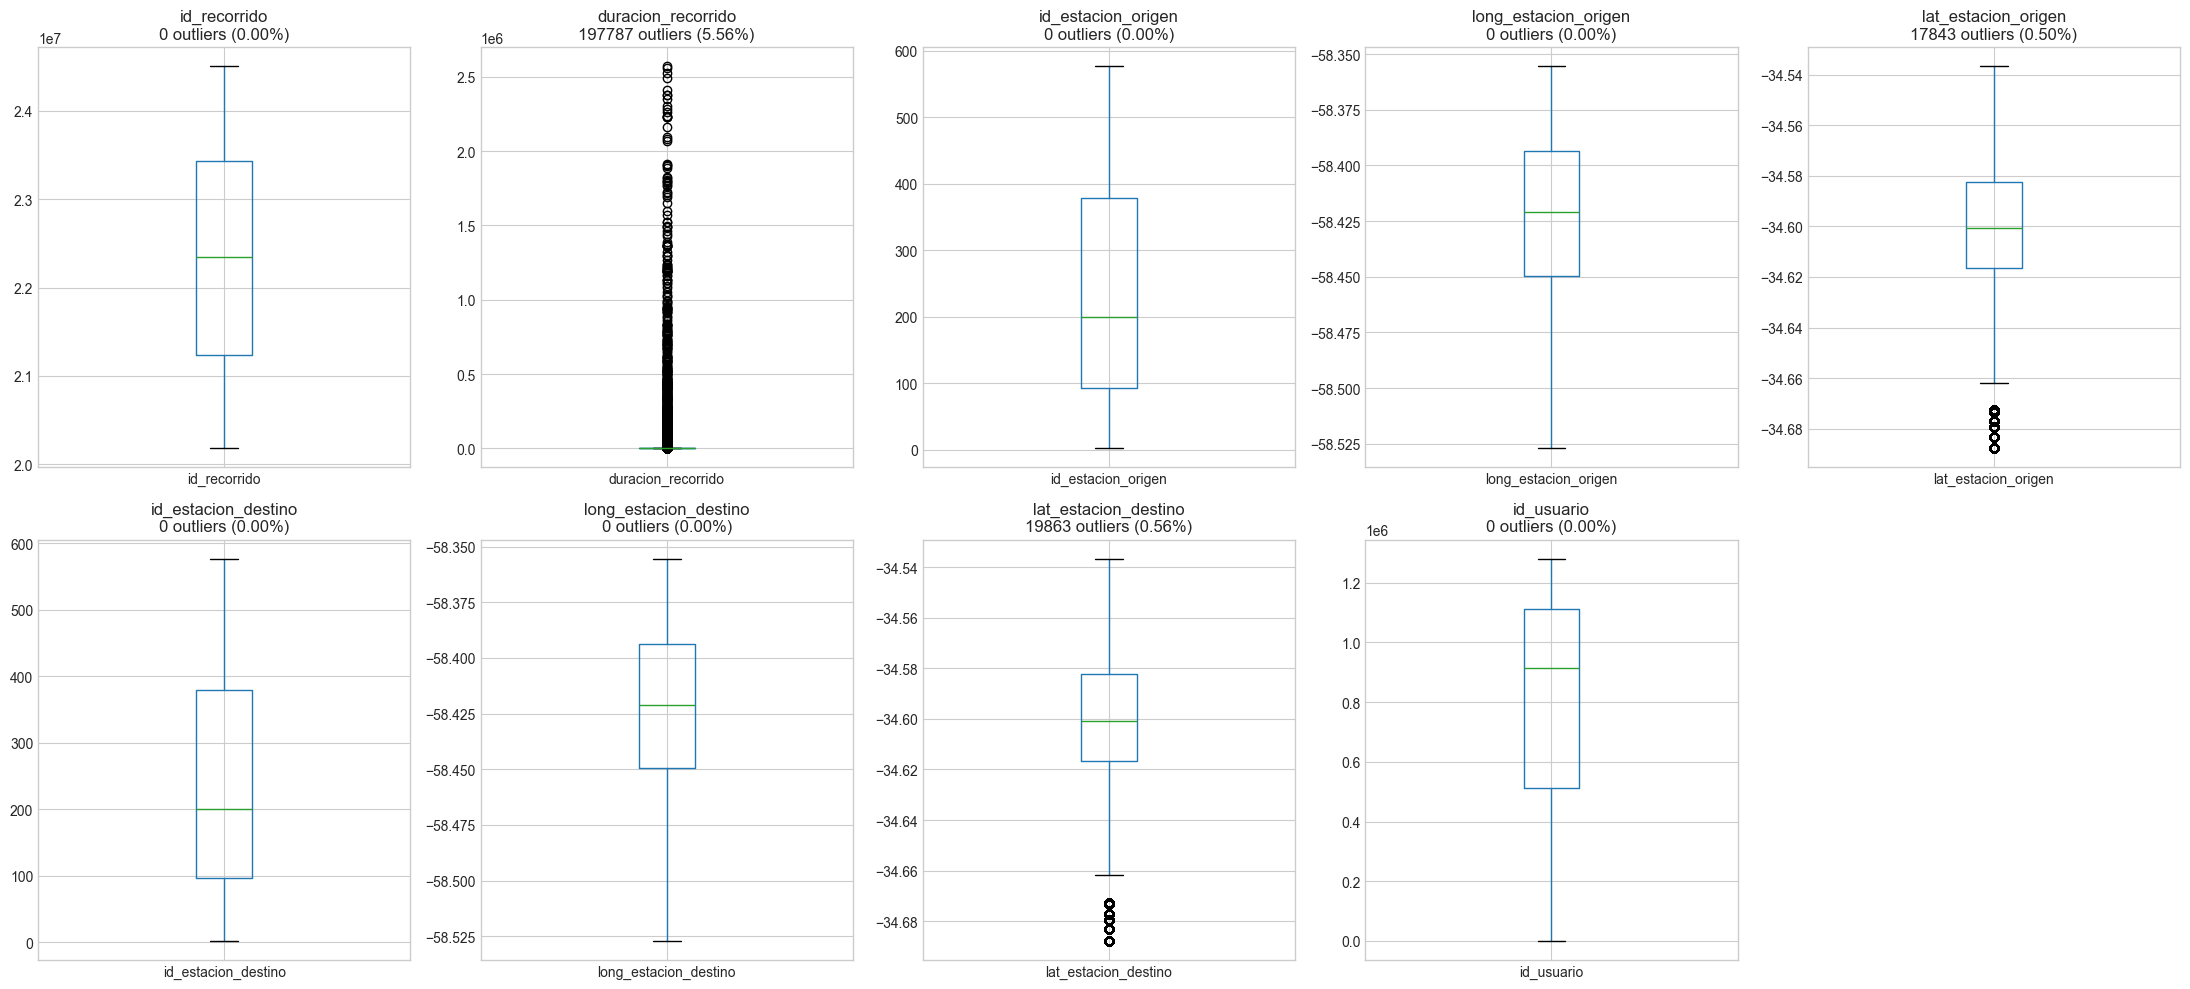

In [ ]:
# Vista global boxplot del posibles Outliers -  dataframe
#df_ecobici.boxplot(figsize=(22,10))


# Seleccionar solo columnas numéricas
numeric_cols = df_ecobici.select_dtypes(include=['number']).columns.tolist()

# Configurar el tamaño del gráfico
plt.figure(figsize=(22, 10))

# Crear subplots para cada columna numérica
for i, column in enumerate(numeric_cols, 1):
    plt.subplot(2, (len(numeric_cols)+1)//2, i)
    
    # Calcular límites de outliers con IQR
    Q1 = df_ecobici[column].quantile(0.25)
    Q3 = df_ecobici[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Crear el box plot
    df_ecobici.boxplot(column=column, ax=plt.gca())
    
    # Añadir título con información sobre outliers
    outliers_count = ((df_ecobici[column] < lower_bound) | (df_ecobici[column] > upper_bound)).sum()
    outliers_percent = (outliers_count / len(df_ecobici)) * 100
    plt.title(f"{column}\n{outliers_count} outliers ({outliers_percent:.2f}%)")

plt.tight_layout()
plt.show()



Como pudimos observer en la. Gráficas <u> Vista global boxplot del posibles Outliers -  dataframe</u> en los campos  duracion_recorrido, lat_estacion_origen y lat_estacion_destino 

---

### Detección de campos Null 
Por medio de la <u>TABLA RESUMEN DE CONTENIDO DEL DATASET </u> pudimos detectar algunos campos con valores NULL,  a hora por medio de las gráficas presentadas a continuación podemos observar en el mapa de calor del **msno.heatmap** los valores NULL de los campos **genero** y **fecha_destino_recorrido** no tienen relación entre si, en otras palabras los registros cuyo campo **genero** son de valor NULL no posee ningún registro NULL en el campo **fecha_destino_recorrido**. 

Podemos observar que los valores de relación entre las gráficas es igual a 0 

<Axes: >

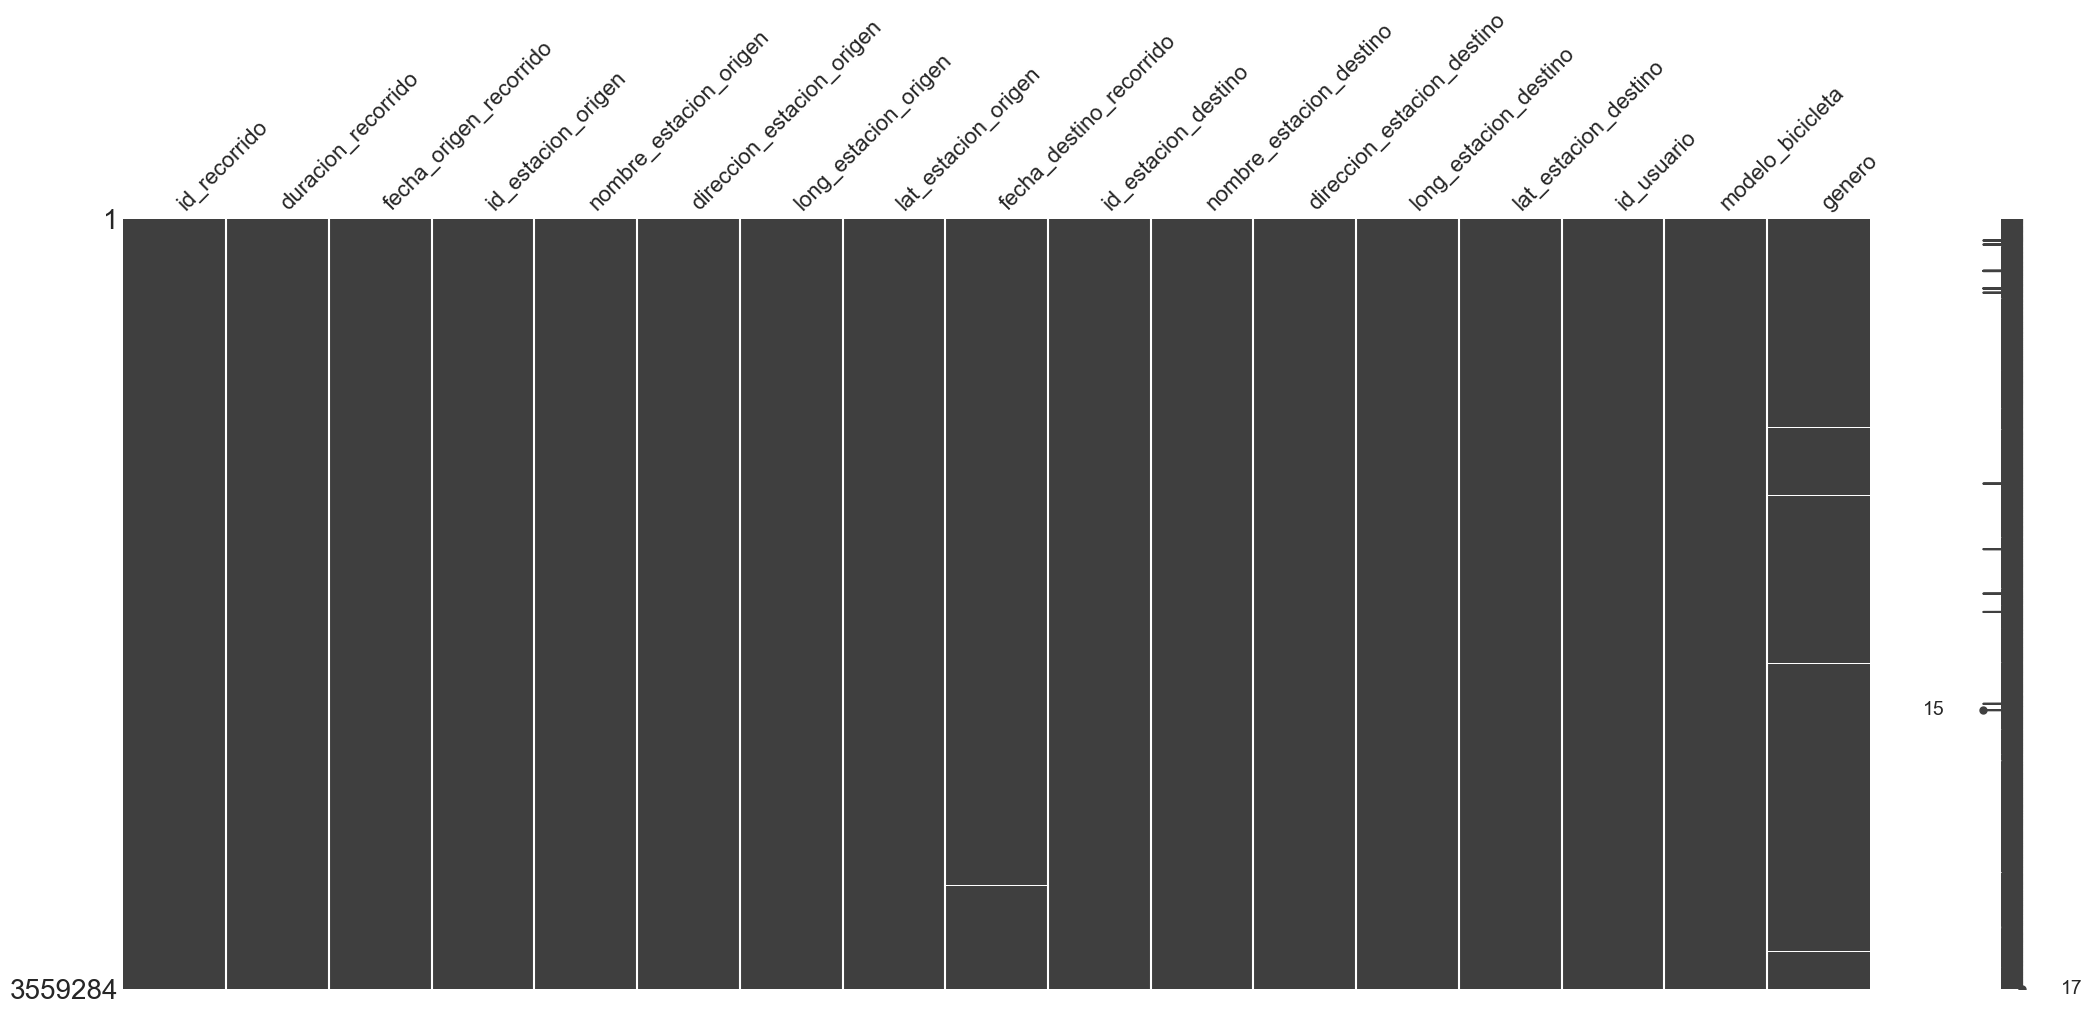

In [19]:
# Gráfica de presencia y el patrón de valores null
# import missingno as msno # pip install missingno
msno.matrix(df_ecobici)

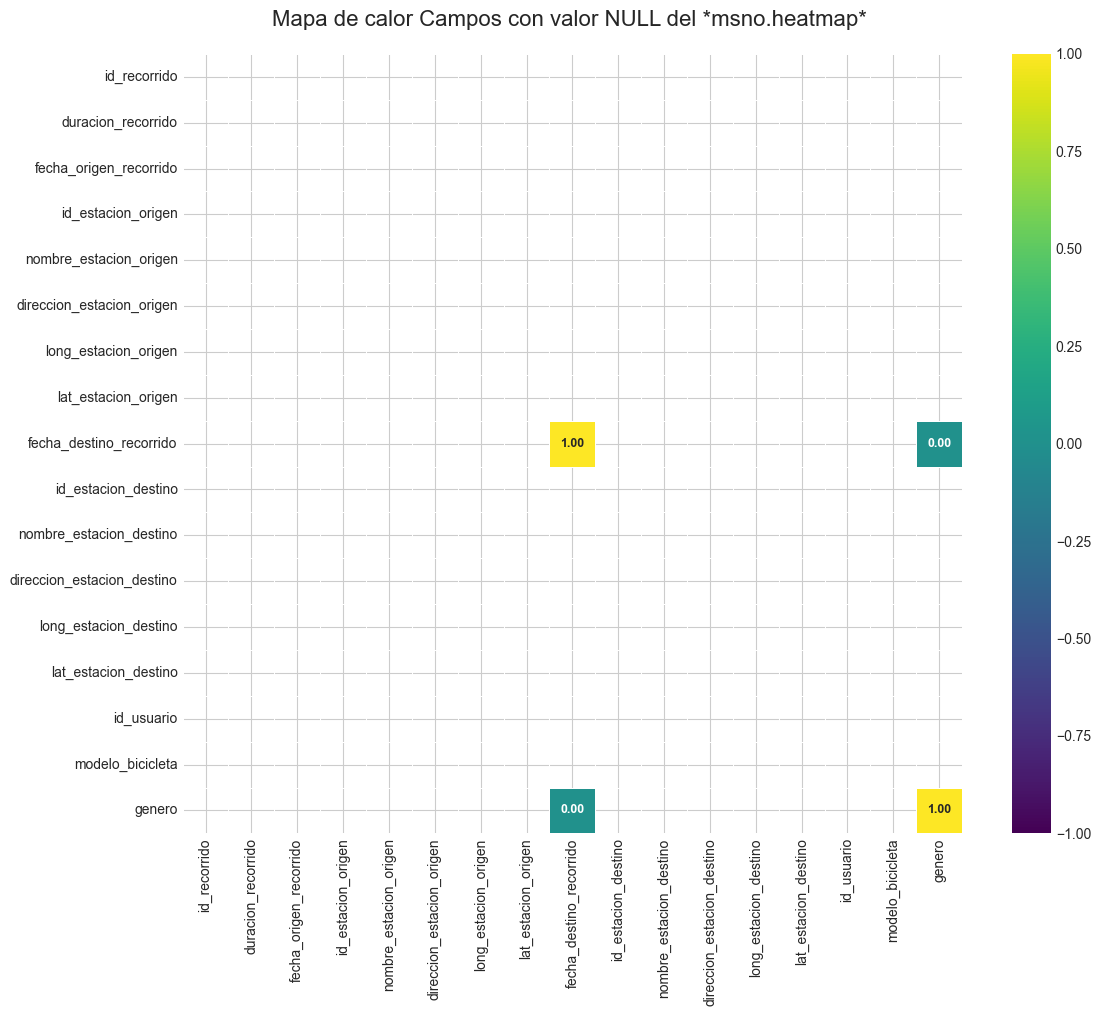

In [20]:
# Matriz  de presencia y el patrón de valores null
#   import missingno as msno 
#   df_ecobici.shape
#   msno.heatmap(df_ecobici)

# NOTA - > COMO NO SE APRECIA LOS NÚMEROS EN LA GRÁFICA DE msno.heatmap(df_ecobici) SE REALIZÓ ESTE MÉTODO
# Crear una matriz de correlación basada en valores nulos
nulls = df_ecobici.isnull() # Todos los Valores NULL
corr_matrix = nulls.corr()

# Crear un mapa de calor con seaborn y mostrar valores
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, 
                     annot=True,            # Mostrar los valores numéricos
                     fmt='.2f',             # Formato con 2 decimales
                     cmap='viridis',        # Paleta de colores fuerte
                     linewidths=0.5,        # Líneas entre celdas
                     annot_kws={"size": 9 ,"weight":"bold"}, # Tamaño de fuente y  negrita de las anotaciones 
                     vmin=-1, vmax=1,       # Escala fija de valores
                     square=True)           # Celdas cuadradas

plt.title('Mapa de calor Campos con valor NULL del *msno.heatmap* ', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Tratamiento de datos NULL campo **genero**

Como vimos anteriormente la población de campos NULL en esta categoría representa el 0,34% de 3559284 registros. como es un población de NULL muy pequeña  y con una tendencia muy marcada se podría reemplazar los valores NULL por la categoría mas frecuente. La mode correspondiente es valor MALE con 2.147.721 viajes (60.34%).

Pero se decide utilizar el método KNN e imputar los valores faltantes. tenemos que realizar primero el One-Hot Encoding en el campo genero y luego el proceso de KNN

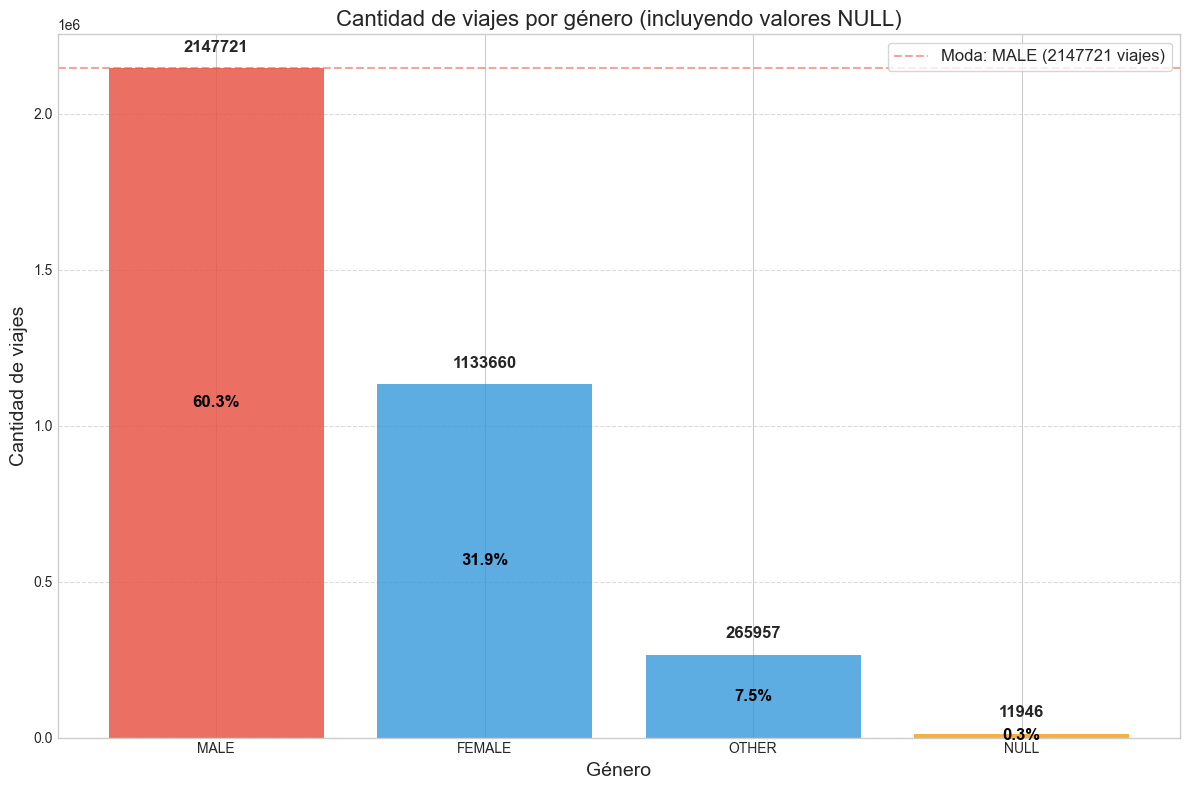

In [22]:
# Tabal de viage por genero con valores NULL 

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# Contar valores nulos
nulos = df_ecobici['genero'].isna().sum()

# Contar viajes por género incluyendo los nulos # value_counts() por defecto excluye los valores nulos.
genero_counts = df_ecobici['genero'].value_counts(dropna=False).sort_values(ascending=False)

# Identificar la moda (el género más frecuente)
try:
    genero_moda = mode(df_ecobici['genero'].dropna())
    moda_es_nula = False
except StatisticsError:
    # Si hay múltiples modas, tomamos la primera
    genero_moda = df_ecobici['genero'].value_counts(dropna=False).index[0]
    moda_es_nula = pd.isna(genero_moda)

# Crear etiquetas para el eje X, reemplazando NaN por "NULL"
labels = [str(x) if pd.notna(x) else "NULL" for x in genero_counts.index]

# Crear colores para las barras
colors = []
for x in genero_counts.index:
    if pd.isna(x) and (moda_es_nula or pd.isna(genero_moda)):
        colors.append('#e74c3c')  # Rojo para NULL si es la moda
    elif x == genero_moda:
        colors.append('#e74c3c')  # Rojo para la moda
    elif pd.isna(x):
        colors.append('#f39c12')  # Naranja para NULL si no es la moda
    else:
        colors.append('#3498db')  # Azul para los demás

# Crear barras
bars = plt.bar(labels, genero_counts.values, color=colors, alpha=0.8)

# Añadir etiquetas con valores
for i, v in enumerate(genero_counts.values):
    plt.text(i, v + (max(genero_counts.values) * 0.02), f'{v}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Añadir título y etiquetas
plt.title('Cantidad de viajes por género (incluyendo valores NULL)', fontsize=16)
plt.xlabel('Género', fontsize=14)
plt.ylabel('Cantidad de viajes', fontsize=14)

# Encontrar el índice de la moda
if moda_es_nula:
    moda_index = list(genero_counts.index).index(np.nan)
    moda_label = "NULL"
else:
    moda_index = list(genero_counts.index).index(genero_moda)
    moda_label = str(genero_moda)

# Destacar la moda en la leyenda
plt.axhline(y=genero_counts.iloc[moda_index], color='#e74c3c', linestyle='--', alpha=0.5)
plt.legend([f'Moda: {moda_label} ({genero_counts.iloc[moda_index]} viajes)'], 
           loc='upper right', frameon=True, fontsize=12)

# Añadir anotación de porcentajes
total_viajes = genero_counts.sum()
for i, (genero, count) in enumerate(genero_counts.items()):
    porcentaje = (count / total_viajes) * 100
    plt.text(i, count/2, f'{porcentaje:.1f}%', 
             ha='center', va='center', color='black', fontweight='bold', fontsize=12)

# Añadir grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar diseño
plt.tight_layout()


plt.show()


### Procesos realizados en el campo genero
1. Asignación de variables category en todo el dataframe

In [34]:
# nuevo  dataframe para la transformación de datos ..  
#################### NOTAL LO PRIMERO QUE SE TIENE QUE HACER ################
df_imputed = df_ecobici.copy()

#print(f'{df_ecobici.dtypes}\n')

# Transformar variables categóricas a tipo category
df_imputed['nombre_estacion_origen'] = df_imputed['nombre_estacion_origen'].astype('category')
df_imputed['nombre_estacion_destino'] = df_imputed['nombre_estacion_destino'].astype('category')
df_imputed['direccion_estacion_origen'] = df_imputed['direccion_estacion_origen'].astype('category')
df_imputed['direccion_estacion_destino'] = df_imputed['direccion_estacion_destino'].astype('category')
df_imputed['modelo_bicicleta'] = df_imputed['modelo_bicicleta'].astype('category')
df_imputed['genero'] = df_imputed['genero'].astype('category') # campo con valor NULL
#df_imputed['id_estacion_origen'] = df_imputed['id_estacion_origen'].astype('category')
#df_imputed['id_estacion_destino'] = df_imputed['id_estacion_destino'].astype('category')



# +++++ testing pruebas ok 
# vemos los tipos de datos actualizados
print("\nAsignación de variables categóricas :")
print(f'\n{df_imputed.dtypes}')

#   # TEsting para ver el contenido de los campos type category en genero 
#   # Limpiar variables mejorar =( Colocar en Otro Campo)
#   #del df_imputed
#   
#   valores_unicos_df_ecobici = df_ecobici['genero'].unique()
#   print(f"\nvalores sin asignar tipo astype('category') campo genero {valores_unicos_df_ecobici}\n")
#   
#   
#   valores_unicos_df_imputed = df_imputed['genero'].unique()
#   print(f"\nRESULTADO ASIGNANDO  astype('category') campo genero {valores_unicos_df_imputed}\n")
#   # por lo que veo los valores NULL son transformados en un valor OTHER


Asignación de variables categóricas :

id_recorrido                     int64
duracion_recorrido               int64
fecha_origen_recorrido          object
id_estacion_origen               int64
nombre_estacion_origen        category
direccion_estacion_origen     category
long_estacion_origen           float64
lat_estacion_origen            float64
fecha_destino_recorrido         object
id_estacion_destino              int64
nombre_estacion_destino       category
direccion_estacion_destino    category
long_estacion_destino          float64
lat_estacion_destino           float64
id_usuario                     float64
modelo_bicicleta              category
genero                        category
dtype: object


In [ ]:
# variabilidad
print(f"variabilidad de los datos originales lo tenémo representado `{explained_variance_suma*100:.3f}`% ")
#explained_variance_suma

variabilidad de los datos originales lo tenémo representado `86.695`% 


### Procesos realizados en el campo genero
2. Preparar los datos para KNN
3. Realizar la imputación por medio del KNN
4. One-Hot Encoding

In [38]:
# Preparar los datos para KNN
# Seleccionar características para imputación (usaremos estas para predecir género)
# Podemos usar características relevantes que podrían tener relación con el género
features_for_knn = [
    'duracion_recorrido',
    'id_estacion_origen', 
    'id_estacion_destino',
    #'lat_estacion_origen',
    #'long_estacion_origen',
    #'lat_estacion_destino',
    #'long_estacion_destino'
]

# Verificar que las columnas existan en el DataFrame
features_for_knn = [col for col in features_for_knn if col in df_imputed.columns]
print(f"Características usadas para KNN: {features_for_knn}")

# Crear DataFrame solo con las características seleccionadas
X = df_imputed[features_for_knn].copy()

# 4 One-Hot Encoding para la columna df_imputed['genero'] (preservando NaN)
# Guardar índices con valores nulos
null_indices = df_imputed['genero'].isna()

# Crear dummies solo para valores no nulos
genero_dummies = pd.get_dummies(df_imputed.loc[~null_indices, 'genero'], prefix='genero')

# Crear un DataFrame de dummies vacío con las mismas columnas para toda la data
all_dummies = pd.DataFrame(0, index=df_imputed.index, columns=genero_dummies.columns)

# Rellenar con los valores reales donde no son nulos
all_dummies.loc[~null_indices] = genero_dummies
# Error -- all_dummies se creó con un tipo de dato específico (posiblemente int64)

# Preparar datos para KNNImputer
# 5Combinar características con dummies
X_with_dummies = pd.concat([X, all_dummies], axis=1)

# Identificar dónde hay valores nulos en genero para imputar después
target_cols = all_dummies.columns.tolist()
rows_to_impute = null_indices

# Paso 6: Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_with_dummies)

# Convertir de vuelta a DataFrame
X_imputed_df = pd.DataFrame(X_imputed, index=X_with_dummies.index, columns=X_with_dummies.columns)

# Paso 7: Reconstruir la columna genero a partir de las dummies imputadas
# 7.1 Extraer solo las columnas dummy de genero
genero_cols = [col for col in X_imputed_df.columns if col.startswith('genero_')]

# 7.2 Para cada fila con género nulo, asignar la categoría con mayor valor imputado
# Crear una serie temporal para almacenar los géneros imputados
imputed_genero = pd.Series(index=df_imputed.index, dtype='object')

for idx in df_imputed.index[null_indices]:
    # Obtener valores imputados para esta fila
    row_values = X_imputed_df.loc[idx, genero_cols]
    # Encontrar la columna con el valor más alto
    max_col = row_values.idxmax()
    # Extraer la categoría del nombre de la columna (quitar el prefijo 'genero_')
    category = max_col.replace('genero_', '')
    # Asignar esta categoría
    imputed_genero[idx] = category

# 7.3 Actualizar el DataFrame original con los valores imputados
df_imputed.loc[null_indices, 'genero'] = imputed_genero[null_indices]

# testing 
print(f"\nValores nulos en 'genero' después de la imputación: {df_imputed['genero'].isna().sum()}")

# Mostrar distribución antes y después
print("\nDistribución de valores de 'genero' antes de la imputación:")
print(df_ecobici['genero'].value_counts(dropna=False))

print("\nDistribución de valores de 'genero' después de la imputación:")
print(df_imputed['genero'].value_counts(dropna=False))


# df_ecobici_imputed = df_imputed.copy()

# del df_imputed

Características usadas para KNN: ['duracion_recorrido', 'id_estacion_origen', 'id_estacion_destino']


C:\Users\SAN\AppData\Local\Temp\ipykernel_33360\2035610512.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True  True ... False  True  True]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_dummies.loc[~null_indices] = genero_dummies
C:\Users\SAN\AppData\Local\Temp\ipykernel_33360\2035610512.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True False False ...  True False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_dummies.loc[~null_indices] = genero_dummies
C:\Users\SAN\AppData\Local\Temp\ipykernel_33360\2035610512.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype in


Valores nulos en 'genero' después de la imputación: 0

Distribución de valores de 'genero' antes de la imputación:
genero
MALE      2147721
FEMALE    1133660
OTHER      265957
NaN         11946
Name: count, dtype: int64

Distribución de valores de 'genero' después de la imputación:
genero
MALE      2147721
FEMALE    1145606
OTHER      265957
Name: count, dtype: int64


In [39]:
#TESTING
#print(f'\n{df_imputed.dtypes}') 

In [67]:
## One-Hot Encoding aplicados a Campos que no contienen  valores NULL
genero_encoded = pd.get_dummies(df_imputed['genero'], prefix='genero')
# Mostramos nuevas Categorías 
print(f"Columnas creadas con One-Hot Encoding: {genero_encoded.columns.tolist()}")

df_imputed = pd.concat([df_imputed, genero_encoded], axis=1)
# Testing 
#df_imputed.sample(5).T 
# df_imputed.isnull().sum()
# df_imputed.sample(5).T 
#print(f'\n{df_imputed.dtypes}')

Columnas creadas con One-Hot Encoding: ['genero_FEMALE', 'genero_MALE', 'genero_OTHER']


In [29]:
# Listamos las propiedades de los registros 
print(f'\n{df_imputed.dtypes}') 


id_recorrido                     int64
duracion_recorrido               int64
fecha_origen_recorrido          object
id_estacion_origen               int64
nombre_estacion_origen        category
direccion_estacion_origen     category
long_estacion_origen           float64
lat_estacion_origen            float64
fecha_destino_recorrido         object
id_estacion_destino              int64
nombre_estacion_destino       category
direccion_estacion_destino    category
long_estacion_destino          float64
lat_estacion_destino           float64
id_usuario                     float64
modelo_bicicleta              category
genero                        category
genero_FEMALE                     bool
genero_MALE                       bool
genero_OTHER                      bool
dtype: object


---

In [69]:
df_imputed.sample(5)

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,...,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,genero_FEMALE,genero_MALE,genero_OTHER,genero_FEMALE,genero_MALE,genero_OTHER
3025379,21846824,1904,2024-05-27 20:30:32,291,244 - UADE,Lima 750,-58.381627,-34.617247,2024-05-27 21:02:16,135,...,-34.597642,753247.0,FIT,MALE,False,True,False,False,True,False
2790624,23842617,644,2024-11-12 16:06:05,35,035 - INGENIERO BUTTY,Ing. E. Butty 291,-58.371847,-34.596425,2024-11-12 16:16:49,57,...,-34.613250,18229.0,FIT,FEMALE,True,False,False,True,False,False
1418584,24070500,500,2024-11-28 09:11:59,14,014 - Pacifico,"Santa Fe Av. & Bullrich, Int. Av.",-58.426387,-34.577424,2024-11-28 09:20:19,308,...,-34.567633,36820.0,FIT,MALE,False,True,False,False,True,False
1197197,22193706,2,2024-06-28 08:51:46,26,026 - JUANA MANSO I,"Manso Juana & De La Barra, Emma",-58.363872,-34.600752,2024-06-28 08:51:48,35,...,-34.596425,575423.0,FIT,MALE,False,True,False,False,True,False
1109866,22249799,1386,2024-07-03 20:20:29,299,221 - CULPINA,Culpina 121,-58.466143,-34.631705,2024-07-03 20:43:35,281,...,-34.613778,549472.0,ICONIC,MALE,False,True,False,False,True,False


### Para respondernos la pregunta **¿Hay diferencias en la duración de los viajes entre hombres y mujeres?**
Se realizó gráfica de barra comparativas e indicando la media en cantidad de viaje y duración 

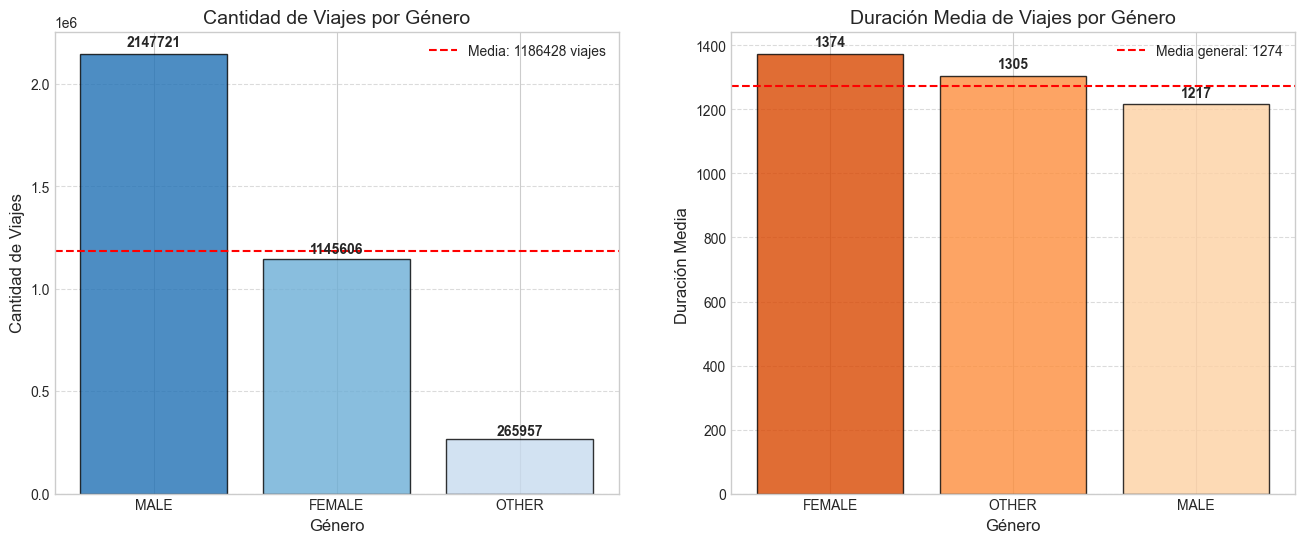

In [ ]:
# Barra comparativa 
# Configuración estética
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 6))

# Crear una matriz 1x2 para las gráficas
plt.subplot(1, 2, 1)

# Gráfica de barras
conteo_genero = df_imputed['genero'].value_counts().sort_values(ascending=False)

# Calcular la media de viajes por género
media_viajes = conteo_genero.mean()

# Crear la primera gráfica - Cantidad de viajes
bars1 = plt.bar(conteo_genero.index, conteo_genero.values, 
               color=sns.color_palette('Blues_r', len(conteo_genero)),
               alpha=0.8, edgecolor='black', linewidth=1)

# Añadir línea horizontal para la media
plt.axhline(y=media_viajes, color='red', linestyle='--', 
            label=f'Media: {int(media_viajes)} viajes')
            
# Añadir etiquetas con valores exactos encima de cada barra
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

# Añadir etiquetas y título
plt.xlabel('Género', fontsize=12)
plt.ylabel('Cantidad de Viajes', fontsize=12)
plt.title('Cantidad de Viajes por Género', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Segunda gráfica - Duración media por género
plt.subplot(1, 2, 2)

# Calcular la duración media por género
# genero está definida como tipo category error en el calculo 
#duracion_media = df_imputed.groupby('genero')['duracion_recorrido'].mean().sort_values(ascending=False) ########3 falla 
duracion_media = df_imputed.groupby('genero', observed=False)['duracion_recorrido'].mean().sort_values(ascending=False)  

# Calcular la media general de duración
media_duracion = df_imputed['duracion_recorrido'].mean()

# Crear la segunda gráfica - Duración media
bars2 = plt.bar(duracion_media.index, duracion_media.values, 
               color=sns.color_palette('Oranges_r', len(duracion_media)),
               alpha=0.8, edgecolor='black', linewidth=1)

# Añadir línea horizontal para la media general
plt.axhline(y=media_duracion, color='red', linestyle='--',
            label=f'Media general: {int(media_duracion)}')

# Añadir etiquetas con valores exactos encima de cada barra
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

# Añadir etiquetas y título
plt.xlabel('Género', fontsize=12)
plt.ylabel('Duración Media ', fontsize=12)
plt.title('Duración Media de Viajes por Género', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()



### Para respondernos la pregunta ** ¿Existen patrones temporales en la cantidad de viajes (horas pico, días de la semana, meses)?**
Se realizó una gráfica lineal realizando el conteo por dia de todo el dataframe

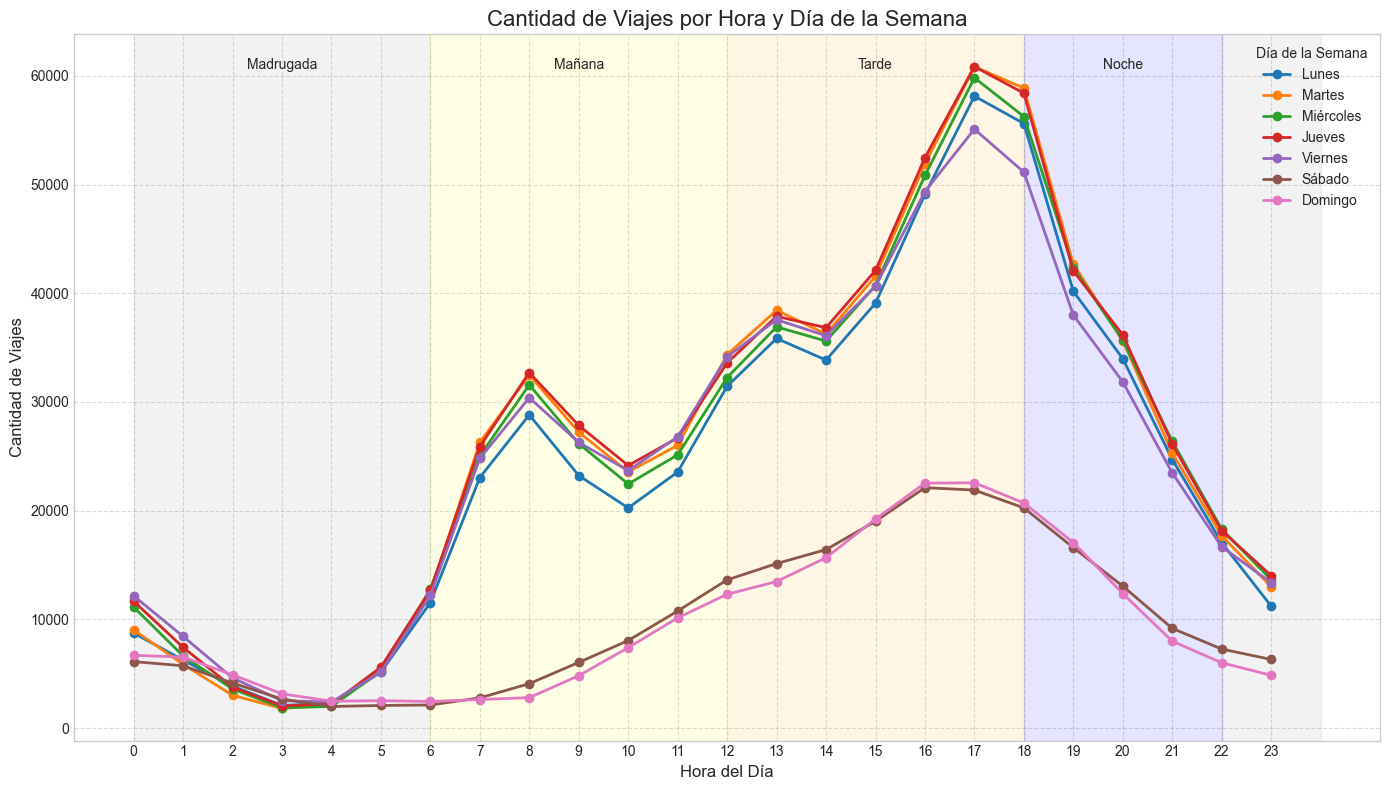

In [54]:
# gráfica lineal

# df-tmp  borrar  temporal de las fechas
df_temp = df_imputed.copy()

# Convertir a datetime si no lo está ya
if not pd.api.types.is_datetime64_any_dtype(df_temp['fecha_origen_recorrido']):
    df_temp['fecha_origen_recorrido'] = pd.to_datetime(df_temp['fecha_origen_recorrido'])

# Extraer hora y día de la semana
df_temp['hora'] = df_temp['fecha_origen_recorrido'].dt.hour
df_temp['dia_semana'] = df_temp['fecha_origen_recorrido'].dt.day_name()

# Definir función para categorizar hora
def categorizar_hora(hora):
    if 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 22:
        return 'Noche'
    else:
        return 'Madrugada'

# Crear el orden de días para la leyenda
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_es = {
    'Monday': 'Lunes', 
    'Tuesday': 'Martes', 
    'Wednesday': 'Miércoles', 
    'Thursday': 'Jueves', 
    'Friday': 'Viernes', 
    'Saturday': 'Sábado', 
    'Sunday': 'Domingo'
}

# Traducir días si es necesario
if df_temp['dia_semana'].iloc[0] in dias_es.keys():
    df_temp['dia_semana'] = df_temp['dia_semana'].map(dias_es)
    orden_dias = [dias_es[dia] for dia in orden_dias]

# Contar viajes por hora y día de la semana
viajes_por_hora = df_temp.groupby(['dia_semana', 'hora']).size().reset_index(name='cantidad_viajes')

# Crear la gráfica de línea
plt.figure(figsize=(14, 8))

# Crear la gráfica con múltiples líneas, una para cada día
for dia in orden_dias:
    subset = viajes_por_hora[viajes_por_hora['dia_semana'] == dia]
    plt.plot(subset['hora'], subset['cantidad_viajes'], marker='o', linewidth=2, label=dia)

# Añadir detalles a la gráfica
plt.title('Cantidad de Viajes por Hora y Día de la Semana', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Cantidad de Viajes', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Día de la Semana', fontsize=10)

# Añadir divisiones visuales para los momentos del día
plt.axvspan(0, 6, alpha=0.1, color='gray')
plt.axvspan(6, 12, alpha=0.1, color='yellow')
plt.axvspan(12, 18, alpha=0.1, color='orange')
plt.axvspan(18, 22, alpha=0.1, color='blue')
plt.axvspan(22, 24, alpha=0.1, color='gray')

# Añadir etiquetas de momento del día
plt.text(3, plt.ylim()[1]*0.95, 'Madrugada', ha='center', fontsize=10)
plt.text(9, plt.ylim()[1]*0.95, 'Mañana', ha='center', fontsize=10)
plt.text(15, plt.ylim()[1]*0.95, 'Tarde', ha='center', fontsize=10)
plt.text(20, plt.ylim()[1]*0.95, 'Noche', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---


Para **Medir la relación entre las variables predictoras** se realizó una matriz de Correlación

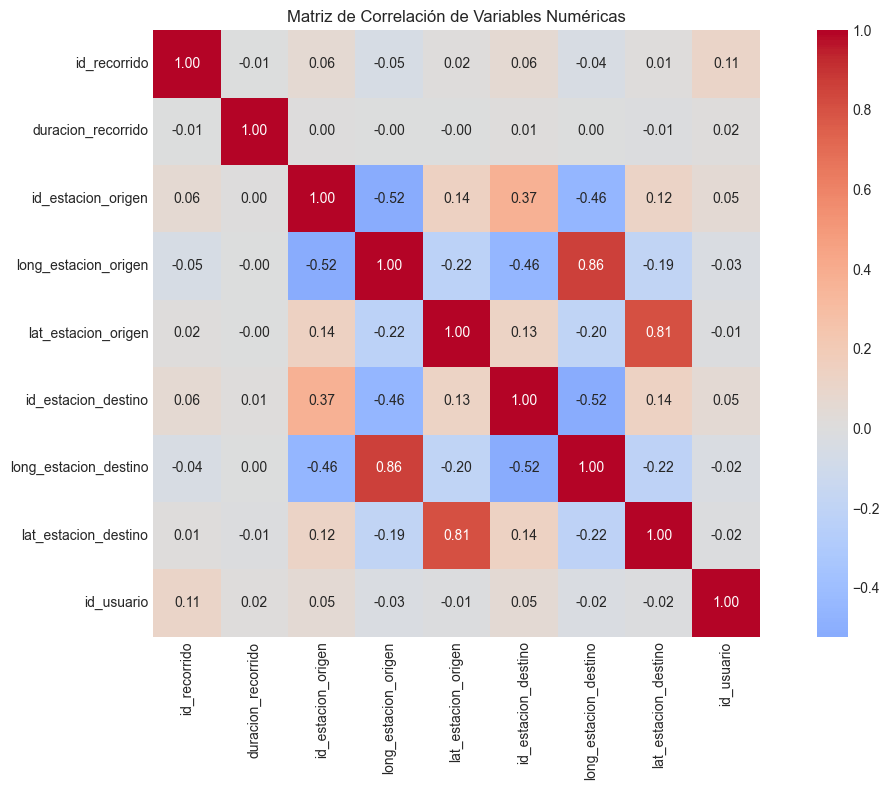

In [55]:
# Seleccionar solo columnas numéricas
numeric_columns = df_imputed.select_dtypes(include=[np.number]).columns
correlation_matrix = df_imputed[numeric_columns].corr()

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True,           # Mostrar valores
            cmap='coolwarm',      # Esquema de colores
            center=0,             # Centrar el colormap en 0
            fmt='.2f',           # Formato de números (2 decimales)
            square=True)          # Hacer las celdas cuadradas

plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()


# Calcular la matriz de correlación
df_numerical_columns_matrix = df_imputed.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numerical_columns_matrix.corr()
varcorrelation = 0.6
# Crear máscara para valores absolutos pero manteniendo el signo original
mask = (abs(correlation_matrix) >= varcorrelation) & (correlation_matrix != 1.0)
filtered_corr = correlation_matrix.where(mask)



<center> <h3>PCA</h3</center>

In [ ]:
# PCA
# Paso 1: Seleccionar las variables para el PCA
# Trabajaremos con la versión del dataframe que ya tiene imputados los valores nulos
df = df_imputed.copy()

# Seleccionar variables numéricas apropiadas para PCA
# Excluimos identificadores y coordenadas si no son relevantes para el análisis
numeric_features = [
    'duracion_recorrido',
    'id_estacion_origen',
    'id_estacion_destino',
    'lat_estacion_origen',
    'long_estacion_origen',
    'lat_estacion_destino',
    'long_estacion_destino'
]

# Verificar que todas las columnas existan en el dataframe
#numeric_features = [col for col in numeric_features if col in df.columns]

# Crear un dataframe con solo las variables seleccionadas
df_X = df[numeric_features].copy()

# Paso 2: Aplicar StandardScaler para normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)
#print("Datos escalados - Primeras 5 filas:")
#print(X_scaled[:5])

# ++++++++++++++++++++++++
# Paso 3: Aplicar PCA
# Inicialmente creamos un PCA con con componentes b componentes
pca = PCA(n_components=4)
# Inicialmente creamos un PCA con el mismo número de componentes que variables 
#pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# --------------------
# Paso 4: Analizar la varianza explicada

# varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
# explained_variance  # contenido del array
explained_variance_suma = pca.explained_variance_ratio_.sum()
# explained_variance_suma  # contenido del array

# varianza acumulada
cumulative_variance = np.cumsum(explained_variance)
# cumulative_variance # contenido del array




In [47]:
explained_variance 


array([0.40762624, 0.22533118, 0.14285334, 0.09114002])

In [ ]:
# variabilidad
print(f"variabilidad de los datos originales lo tenémo representado `{explained_variance_suma*100:.3f}`% ")
#explained_variance_suma

variabilidad de los datos originales lo tenémo representado `86.695`% 


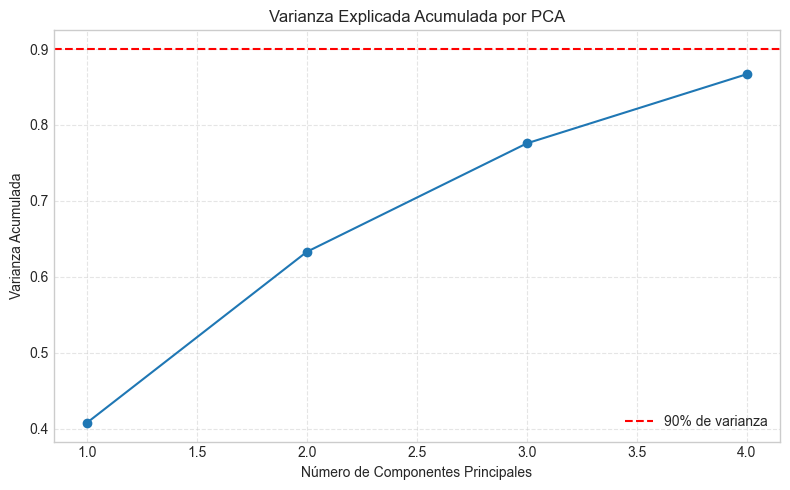

In [49]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\SAN\AppData\Local\Temp\ipykernel_33360\3040224742.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


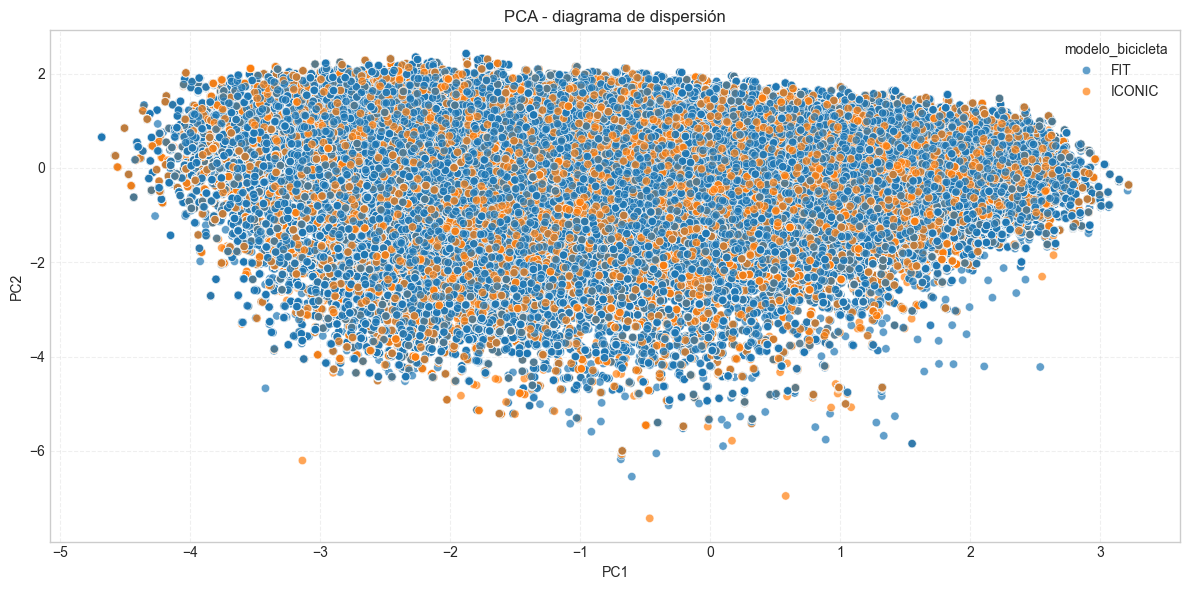

In [ ]:
# Resultado PCA - diagrama de dispersión 
df_components = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# (Opcional) Información adicional: Driver, Team, etc.
df_components['genero'] = df_imputed.loc[df_X.index, 'genero'].values
df_components['modelo_bicicleta'] = df_imputed.loc[df_X.index, 'modelo_bicicleta'].values



# diagrama de dispersión modelo_bicicleta

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='modelo_bicicleta', alpha=0.7)
plt.title('PCA - diagrama de dispersión')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


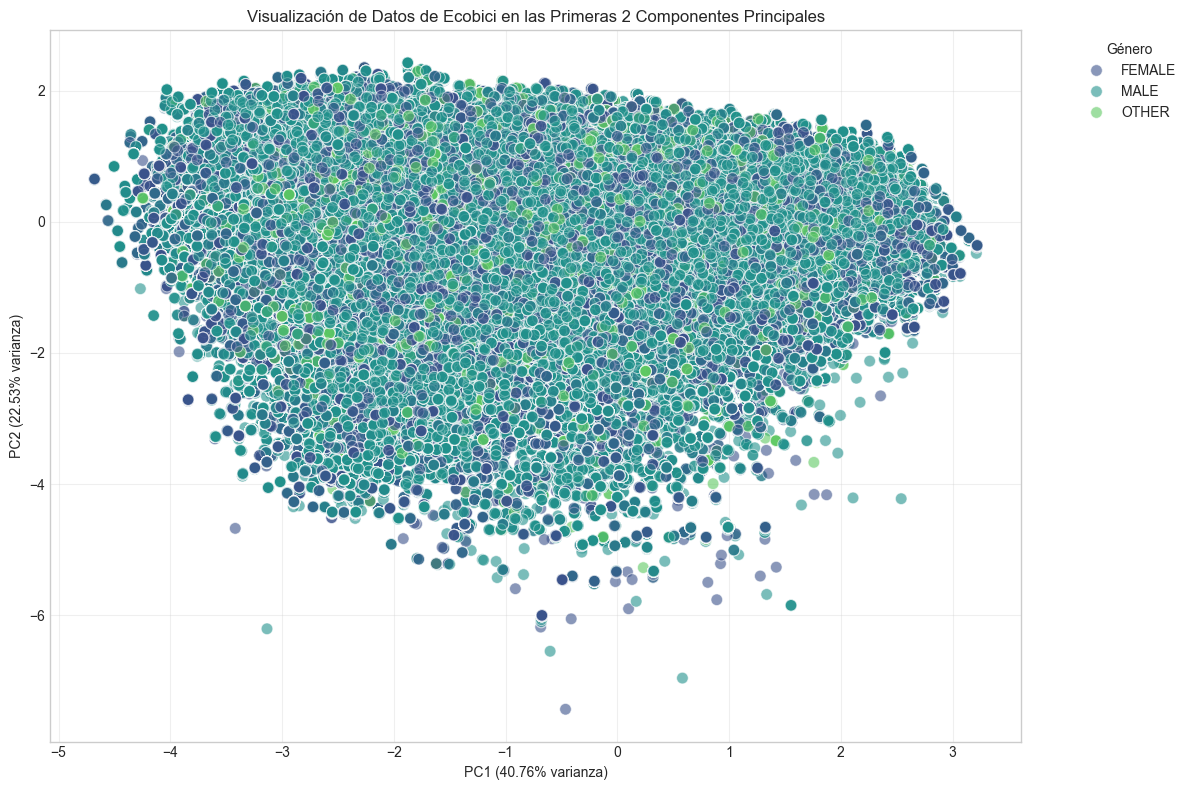

In [ ]:
# PCA - diagrama de dispersión
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='genero',  # Colorear por género
    data=df_components,
    palette='viridis',
    alpha=0.6,
    s=70
)

# Añadir títulos con información sobre la varianza explicada
plt.title('Visualización de Datos de Ecobici en las Primeras 2 Componentes Principales')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} varianza)')
plt.grid(True, alpha=0.3)
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()